In [1]:
import time
from typing import Callable, List

import numpy as np
import torch
from matplotlib import pyplot as plt

import quairkit as qkit
from quairkit import Circuit, State, Hamiltonian
from quairkit.database import *
from quairkit.loss import *

In [3]:
# 设置随机种子保证结果可以复现
qkit.set_seed(1797587035)  # 

机器学习中不同的节点 → 参数化量子门（如旋转门 $U(\theta)$）  
网络层 → 量子门序列（如旋转 + CNOT）  
参数：如量子门的旋转角    

**向前传播**:计算量子态在参数化量子电路中的演化。  
初始态：$\vert \psi^{(0)} \rangle$（比如量子电路的初始量子态 ）  
逐层演化：第 l 层用参数化量子门 $U_l(\theta^{(l)})$ 操作，得到 l 层输出态：$\vert \psi^{(l)} \rangle = U_l(\theta^{(l)}) \vert \psi^{(l-1)} \rangle$    
最终输出：经过 N 层后，得到 $\vert \psi^{(N)} \rangle$，再用损失函数 L 计算 “预测输出” 与 “目标值” 的误差。    

**反向传播**:计算 “损失函数对量子门参数的梯度”，指导参数更新。  
从最终层的损失 L 反向推导，计算第 l 层第 j 个参数 $\theta_j^{(l)}$ 的梯度





##### 参数化量子电路（Parameterized Quantum Circuit, PQC）    
由含可调参数的量子门组成的量子电路（比如旋转门 $R_y(\theta)$，角度 $\theta$ 是可训练参数 ）。  
作为 “量子版的参数化模型”，用经典优化算法迭代调整参数，最小化 “量子损失函数”（比如让量子态更接近目标态、让哈密顿量期望更小 ）  
类比：输入层为初始量子态，隐藏层为量子门（含可调参数的旋转门 + 固定纠缠门 ），输出层为最终量子态/"可观测的期望值"(比如哈密顿量的能量)


量子电路里没法直接用经典的反向传播，而是用参数平移（Parameter Shift） 等技巧算梯度：
通过 “微调量子门参数，观察损失变化”，间接算出损失对参数的梯度，再用梯度下降更新参数

##### 变分量子本征求解器（Variational Quantum Eigensolver, VQE）  
找哈密顿量 H 的最低本征值（对应量子系统的基态能量 ）   
变分原理：哈密顿量的期望值是基态能量的下界。即对任意量子态 $|\psi\rangle$，有：$\langle \psi | H | \psi \rangle \geq E_0$（$E_0$ 是真实基态能量）

用参数化量子电路（PQC）生成变分量子态 $|\psi(\theta)\rangle$（$\theta$ 是电路参数 ）  
最小化 “哈密顿量的期望值” $\langle \psi(\theta) | H | \psi(\theta) \rangle$，逼近真实基态能量 $E_0$：
$\lambda_0 = \min_\theta \langle \psi(\theta) | H | \psi(\theta) \rangle$

VQE的应用：  
伊辛模型(ising model)  
哈密顿量形式：$H = -\sum_{i=1}^{N-1} Z_i Z_{i+1} + \sum_{i=1}^N X_i$  
用 VQE 求解伊辛模型的哈密顿量基态，就能得到 “系统的最低能量态”

↓↓创建一个用于 VQE 算法的参数化量子电路（PQC），通过指定量子比特数量和电路深度来控制电路的复杂度。  

In [ ]:
def construct_cir(num_qubits: int, #电路中包含的量子比特数量
                  depth: int #电路中训练层的数量，深度越大，电路的表达能力通常越强，但训练难度也可能增加
                  ) -> Circuit:
    r"""Construct the quantum circuit for the variational quantum eigensolver.
    
    Args:
        num_qubits: number of qubits in the quantum circuit.
        depth: number of training layers in the circuit.
    
    Returns:
        the target quantum circuit
    
    """
    circuit = Circuit(num_qubits)#创建电路对象

    # add qubit gates to the circuit
    circuit.complex_entangled_layer(qubits_idx=list(range(num_qubits)), #指定该层作用于所有量子比特
                                    depth=depth)

    return circuit

In [5]:
#量子神经网络损失函数
def loss_fcn(cir: Circuit, 
             #↓↓ 一个 “期望值函数”，接收量子态（State 对象）作为输入，
             # 返回该态在某个可观测量（如哈密顿量 H）下的期望值（标量张量）
             exp_val: Callable[[State], torch.Tensor]) -> torch.Tensor:
    r"""Compute the loss function of the quantum neural network.
    
    Args:
        cir: the input PQC
        exp_val: the expectation value function
    
    Returns:
        the loss value

    """
    #默认以初始态 \(|0>^{\otimes n}\)（n 为量子比特数）为输入
    output = cir()  
    #计算期望值作为损失
    return exp_val(output) 

In [ ]:
# 可视化变分量子算法的训练结果
def display_results(loss_list: List[float], #训练过程中记录的损失值列表（通常是每轮迭代的能量期望值）
                    lambda_0: int, #理论上的基态能量（真实最小值）
                    circuit: Circuit #训练完成的参数化量子电路（PQC）
                    ) -> None:
    r"""Plot the training process and the final circuit.

    Args:
        loss_list: the list of loss values during the training process
        lambda_0: the ground-state energy
        circuit: the final circuit

    """

    print("\n" + "-" * 100 + "\n")  # a line of '-' for better readability
    print("Circuit after training:")

    circuit.plot()  # plot the circuit

    num_itr = len(loss_list) #迭代次数
    base_line = lambda_0 * torch.ones(num_itr) #基线能量线（理论基态能量的水平线）
    list_itr = list(range(num_itr)) #迭代次数序列


    print("\n" + "-" * 100 + "\n")  # a line of '-' for better readability
    print("Training process:")


    plt.plot(
        list_itr,
        loss_list,
        alpha=0.7,
        marker="",
        linestyle="-",
        color="r",
        #变分能量曲线
        label=r"$\left\langle {\psi \left( {\theta } \right)} \right|"
        + r"H\left| {\psi \left( {\theta } \right)} \right\rangle $",
    )
    plt.plot(
        list_itr,
        base_line,
        alpha=0.7,
        marker="",
        linestyle=":",
        color="b",
        #基态能量基准线
        label="Ground-state energy $\lambda_0$",
    )
    plt.xlabel("Number of iteration")
    plt.ylabel(r"Energy $\lambda_0$")
    plt.legend(loc="best")
    plt.show()

用VQE找到了这个伊辛模型哈密顿量的最低本征值（基态能量）

In [7]:
def train_model(num_itr: int, #训练迭代次数（优化步数）
                LR: float, #初始学习率（控制参数更新的步长）
                num_qubits: int, #量子电路的量子比特数量
                depth: int, #参数化量子电路的深度（决定电路复杂度）
                H: Hamiltonian #目标哈密顿量（需要求解基态能量的物理系统）
                ) -> None:

    # 构建PQC
    cir = construct_cir(num_qubits, depth)


    #计算哈密顿量的理论基态能量（作为参考基准）
    eigenvalues = torch.linalg.eigvalsh(H.matrix)#  #计算哈密顿量的本征值

    lambda_0 = torch.min(torch.real(eigenvalues))# 最小本征值即基态能量

    #定义能量期望值计算函数（损失函数的核心）
    exp_val = ExpecVal(H) ## 接收量子态，返回其在H下的能量期望 <ψ|H|ψ>

    loss_list, time_list = [], []

    # 优化器：用Adam算法更新电路参数（量子门的旋转角等）
    opt = torch.optim.Adam(lr=LR, params=cir.parameters())

    # 学习率调度器：当损失不再下降时，自动减小学习率（精细优化）
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, "min", factor=0.5)

    print("Training:")
    for itr in range(num_itr):
        start_time = time.time()
        opt.zero_grad()
        
        # 计算损失，即<ψ(θ)|H|ψ(θ)>
        loss = loss_fcn(cir, exp_val)  # compute loss

        loss.backward()  # compute gradients
        opt.step()  #  Adam优化器更新参数
        scheduler.step(loss)  #调度器根据损失调整学习率

        loss = loss.item()
        loss_list.append(loss)
        time_list.append(time.time() - start_time)

        # 每20次迭代或最后一次迭代打印一次损失和学习率
        if itr % 20 == 0 or itr == num_itr - 1:
            print(
                f"iter: {itr}, loss: {loss:.8f}, lr: {scheduler.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s"
            )
            time_list = []
    
    display_results(loss_list, lambda_0, cir)

Training:
iter: 0, loss: -0.36181247, lr: 5.00E-02, avg_time: 0.0538s
iter: 20, loss: -2.69505453, lr: 5.00E-02, avg_time: 0.0047s
iter: 40, loss: -3.01261377, lr: 5.00E-02, avg_time: 0.0088s
iter: 60, loss: -3.40792847, lr: 5.00E-02, avg_time: 0.0080s
iter: 80, loss: -3.49100828, lr: 5.00E-02, avg_time: 0.0105s
iter: 100, loss: -3.49361849, lr: 5.00E-02, avg_time: 0.0083s
iter: 120, loss: -3.49383664, lr: 5.00E-02, avg_time: 0.0050s
iter: 140, loss: -3.49391365, lr: 5.00E-02, avg_time: 0.0073s
iter: 160, loss: -3.49394178, lr: 5.00E-02, avg_time: 0.0067s
iter: 180, loss: -3.49395227, lr: 5.00E-02, avg_time: 0.0075s
iter: 199, loss: -3.49395680, lr: 5.00E-02, avg_time: 0.0073s

----------------------------------------------------------------------------------------------------

Circuit after training:


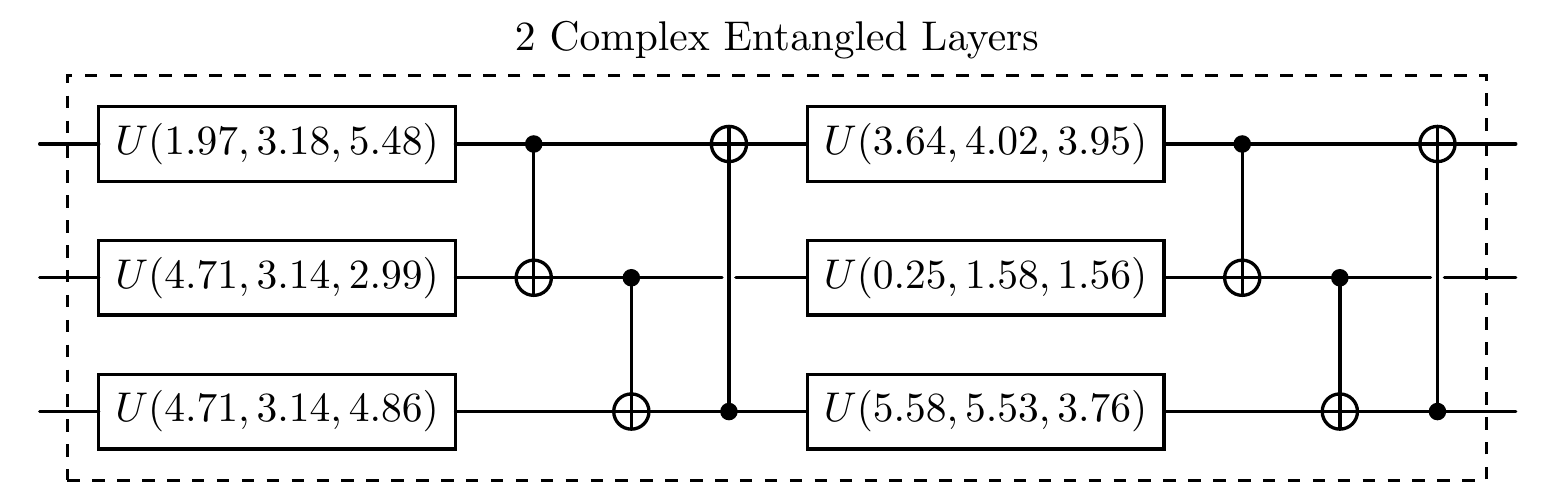


----------------------------------------------------------------------------------------------------

Training process:


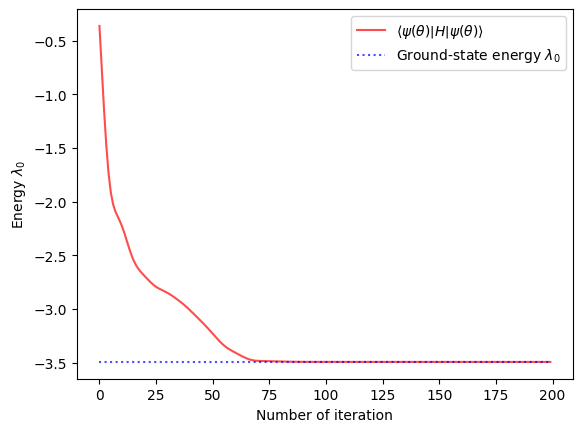

In [ ]:
# 构建 3 节点自旋系统的伊辛模型
num_qubits = 3  

NUM_ITR = 200  # number of iterations for training
LR = 0.05  # learning rate for training
depth = 2  # depth of the circuit

edges = -torch.tensor([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
vertices = torch.tensor([1, 1, 1])
hamiltonian = ising_hamiltonian(edges, vertices)  # the Ising Hamiltonian

train_model(NUM_ITR, LR, num_qubits, depth, hamiltonian)